# **PHASE - 1: Data Loading**

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

folder_path_f = "/content/drive/MyDrive/Colab Notebooks/ML_Project/fcopy"
folder_path_m = "/content/drive/MyDrive/Colab Notebooks/ML_Project/mcopy"

file_list_f = sorted([f for f in os.listdir(folder_path_f) if f.endswith(".csv")])
file_list_m = sorted([f for f in os.listdir(folder_path_m) if f.endswith(".csv")])

print(f"Total files found in F folder: {len(file_list_f)}")
print(f"Total files found in M folder: {len(file_list_m)}")

def load_matrix(file_path):
    df = pd.read_csv(file_path, header=None, dtype=str)
    df = df.iloc[1:, 1:83]
    df = df.apply(pd.to_numeric, errors='coerce')

    nan_count = df.isna().sum().sum()

    df.fillna(0, inplace=True)

    return df.to_numpy().flatten(), nan_count

total_nan = 0
data_list = []
labels = []

# Processing M folder files with label 1
for file in tqdm(file_list_m, desc = "Processing M folder"):
    file_path = os.path.join(folder_path_m, file)
    matrix, nan_count = load_matrix(file_path)
    total_nan += nan_count
    data_list.append(matrix)
    labels.append(1)

# Processing F folder files with label 0
for file in tqdm(file_list_f, desc = "Processing F folder"):
    file_path = os.path.join(folder_path_f, file)
    matrix, nan_count = load_matrix(file_path)
    total_nan += nan_count
    data_list.append(matrix)
    labels.append(0)

print(f"Total number of NaN values filled: {total_nan}")

df = pd.DataFrame(data_list)
df['Label'] = labels  # Ensuring Label is correctly added as the last column



Mounted at /content/drive
Total files found in F folder: 436
Total files found in M folder: 351


Processing M folder:   0%|          | 0/351 [00:00<?, ?it/s]

Processing F folder:   0%|          | 0/436 [00:00<?, ?it/s]

Total number of NaN values filled: 0


# **PHASE - 2: Normalization & EDA**

**Data Normalization**

In [ ]:
def normalize_features(row_vector):
    """Normalizing only numeric columns, keeping the label unchanged."""
    features = row_vector[:-1]  # Exclude label column
    min_val = np.min(features)
    max_val = np.max(features)

    # Normalizing only if the range is valid
    if max_val - min_val == 0:
        normalized_features = features  # Keeping original if all values are the same
    else:
        normalized_features = (features - min_val) / (max_val - min_val)

    return np.concatenate([normalized_features, [row_vector[-1]]])  # Adding label back

# Ensuring only numeric values are processed
df = df.apply(pd.to_numeric, errors='coerce')  # Converting all columns to numeric
df.fillna(0, inplace=True)  # Replacing NaNs with 0

# Apply normalization
normalized_data = np.array([normalize_features(row) for row in df.to_numpy()])
print("Normalization complete. Sample row (first 5 values + label):")
print(normalized_data[0][:5], "Label:", normalized_data[0][-1])

np.save("normalized_data.npy", normalized_data)
print("✅ Data successfully saved as normalized_data.npy")
print(len(normalized_data[1]))

Normalization complete. Sample row (first 5 values + label):
[1.         0.20292337 0.179414   0.09581943 0.12378303] Label: 1.0
✅ Data successfully saved as normalized_data.npy
6725


**Exploratory Data Analysis (EDA)**

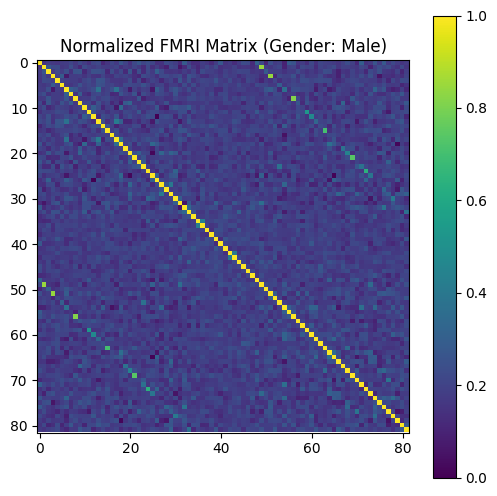

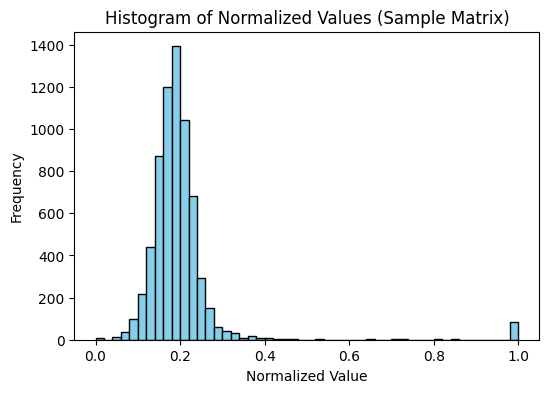

Overall Statistics across all matrices:
Mean: 0.2069
Standard Deviation: 0.1071
Minimum value: 0.0000
Maximum value: 1.0000


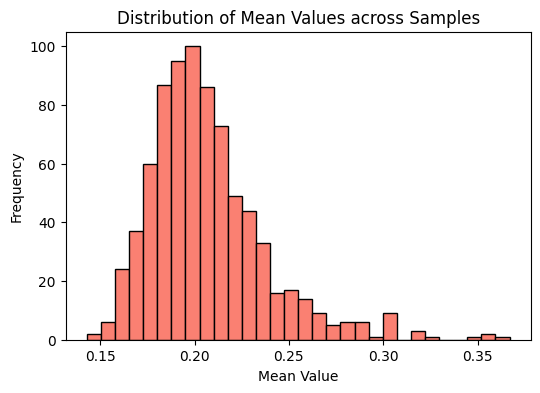

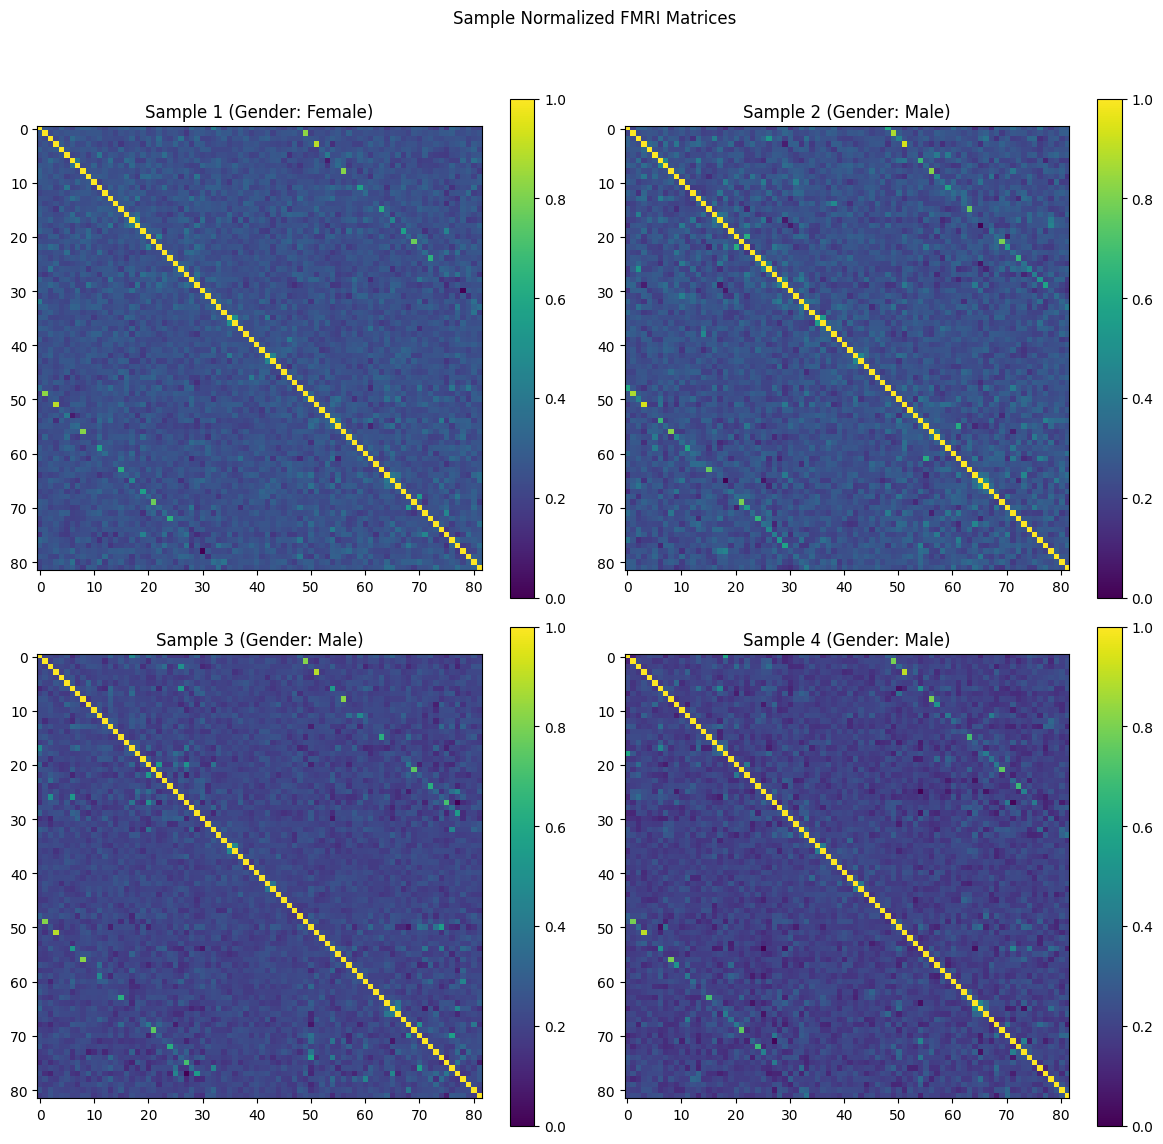

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

sample_index = random.randint(0, normalized_data.shape[0] - 1)
sample_vector = normalized_data[sample_index, :-1]
sample_label = normalized_data[sample_index, -1]

sample_matrix = sample_vector.reshape(82, 82)

# Plotting the normalized matrix
plt.figure(figsize=(6, 6))
plt.imshow(sample_matrix, cmap='viridis')
plt.colorbar()
plt.title(f"Normalized FMRI Matrix (Gender: {'Male' if sample_label == 1 else 'Female'})")
plt.show()

# Plotting histogram of values
plt.figure(figsize=(6, 4))
plt.hist(sample_matrix.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Normalized Values (Sample Matrix)")
plt.xlabel("Normalized Value")
plt.ylabel("Frequency")
plt.show()

# Computing statistics across all matrices
matrix_stats = {
    'min': np.min(normalized_data[:, :-1]),
    'max': np.max(normalized_data[:, :-1]),
    'mean': np.mean(normalized_data[:, :-1]),
    'std': np.std(normalized_data[:, :-1])
}

print("Overall Statistics across all matrices:")
print(f"Mean: {matrix_stats['mean']:.4f}")
print(f"Standard Deviation: {matrix_stats['std']:.4f}")
print(f"Minimum value: {matrix_stats['min']:.4f}")
print(f"Maximum value: {matrix_stats['max']:.4f}")

# Plot distribution of mean values across samples
all_means = np.mean(normalized_data[:, :-1], axis=1)  # mean per sample

plt.figure(figsize=(6, 4))
plt.hist(all_means, bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Mean Values across Samples")
plt.xlabel("Mean Value")
plt.ylabel("Frequency")
plt.show()

# Selecting 4 random samples for visualization
sample_indices = random.sample(range(normalized_data.shape[0]), 4)

plt.figure(figsize=(12, 12))
for idx, sample_idx in enumerate(sample_indices):
    sample_matrix = normalized_data[sample_idx, :-1].reshape(82, 82)
    sample_label = normalized_data[sample_idx, -1]  # Get gender label

    plt.subplot(2, 2, idx + 1)
    plt.imshow(sample_matrix, cmap='viridis')
    plt.title(f"Sample {idx+1} (Gender: {'Male' if sample_label == 1 else 'Female'})")
    plt.colorbar()

plt.suptitle("Sample Normalized FMRI Matrices")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **PHASE 3: Feature Extraction & Classification**

In [ ]:
reshaped_data_list = [data.reshape(82, 82) for data in data_list]

fmri_matrices = np.array(reshaped_data_list)
labels = np.array(labels)

print("Shape of fmri_matrices:", fmri_matrices.shape)
print("Shape of labels:", labels.shape)

import pickle

with open('/content/drive/MyDrive/Colab Notebooks/ML_Project/fmri-labels.pkl', 'wb') as f:
    pickle.dump(labels, f)
    print("✅ Labels saved to the pickle file")

Shape of fmri_matrices: (787, 82, 82)
Shape of labels: (787,)
✅ Labels saved to the pickle file


**Tangent Space Embedding**

In [ ]:
!pip install -q nilearn
from nilearn.connectome import ConnectivityMeasure

# Initialize Tangent Space Embedding
tangent_embedder = ConnectivityMeasure(kind='tangent')

# Extracting features
tangent_features = tangent_embedder.fit_transform(fmri_matrices)

print("Tangent features shape:", tangent_features.shape)

with open('/content/drive/MyDrive/Colab Notebooks/ML_Project/fmri-tangent-features.pkl', 'wb') as f:
    pickle.dump(tangent_features, f)
    print("✅ Tangent Features saved to the pickle file")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 55.2 MB/s eta 0:00:00
Tangent features shape: (787, 82, 82)
✅ Tangent Features saved to the pickle file


**Classification using SVM**

In [ ]:
!pip install -q pyriemann

import numpy as np
from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import Covariances
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 1. Computing covariance matrices
cov_matrices = Covariances().fit_transform(fmri_matrices)

# 2. Regularizing to ensure positive definiteness
epsilon = 1e-6
cov_matrices_reg = cov_matrices + np.eye(cov_matrices.shape[-1]) * epsilon

# 3. Tangent space embedding
tangent_embedder = TangentSpace(metric='riemann')
tangent_features = tangent_embedder.fit_transform(cov_matrices_reg)

print("Cov matrices shape:", cov_matrices_reg.shape)
print("Tangent features shape:", tangent_features.shape)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    tangent_features, labels, test_size=0.2, random_state=42
)

# 5. Train SVM classifier
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# 6. Predict & Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Classification Accuracy:", accuracy)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.7/121.7 kB 4.9 MB/s eta 0:00:00
Cov matrices shape: (787, 82, 82)
Tangent features shape: (787, 3403)
Classification Accuracy: 0.6772151898734177


In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/ML_Project/fmri-tangent-features.pkl', 'wb') as f:
    pickle.dump(tangent_features, f)
    print("✅ Tangent Features saved to the pickle file")

In [ ]:
import pickle

from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/Colab Notebooks/ML_Project/fmri-tangent-features.pkl', 'rb') as f:
    tangent_features = pickle.load(f)
    print("✅ Tangent Features saved to the pickle file")

**Visualization with t-SNE**

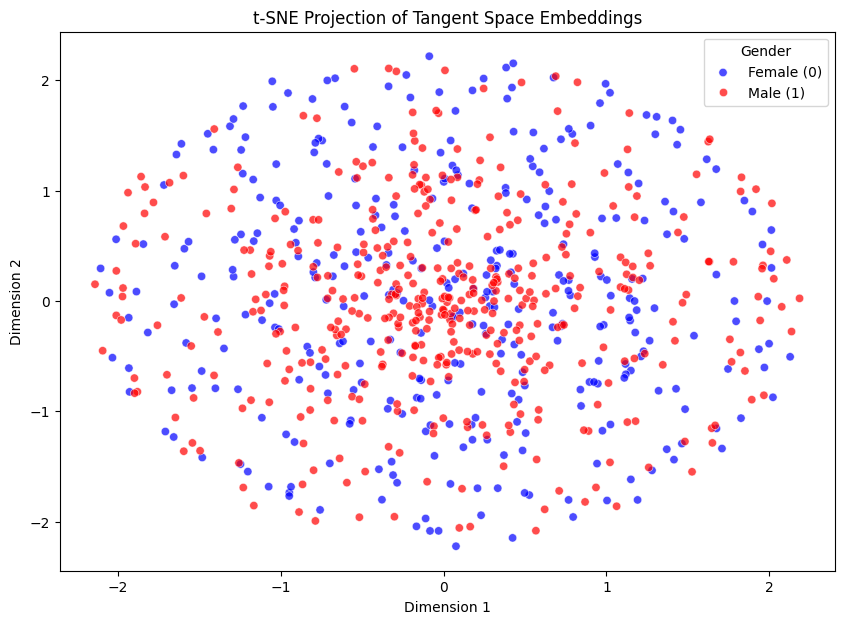

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(tangent_features)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette=['red', 'blue'], alpha=0.7)
plt.title('t-SNE Projection of Tangent Space Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Gender', labels=['Female (0)', 'Male (1)'])
plt.show()

**Feature Selection and Model Comparison**

In [ ]:
!pip install -q lightgbm xgboost

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Data Preparation

# Train/Test Split (using same split for all experiments)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    tangent_features, labels, test_size=0.2, random_state=42
)

# Step 2: Feature Selection Methods
def select_kbest(X_train, y_train, X_test, k=500):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_new = selector.fit_transform(X_train, y_train)
    X_test_new = selector.transform(X_test)
    return X_train_new, X_test_new

def select_rfe(X_train, y_train, X_test, n_features=500):
    base_model = LogisticRegression(max_iter=1000, n_jobs=-1)
    selector = RFE(estimator=base_model, n_features_to_select=n_features, step=50)
    X_train_new = selector.fit_transform(X_train, y_train)
    X_test_new = selector.transform(X_test)
    return X_train_new, X_test_new

def select_l1(X_train, y_train, X_test):
    l1_model = LogisticRegression(penalty='l1', solver='saga', max_iter=5000)
    l1_model.fit(X_train, y_train)
    selector = SelectFromModel(l1_model, prefit=True)
    X_train_new = selector.transform(X_train)
    X_test_new = selector.transform(X_test)
    return X_train_new, X_test_new

# Step 3: Classifiers
def run_random_forest(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred)

def run_xgboost(X_train, y_train, X_test, y_test):
    xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred)

def run_lightgbm(X_train, y_train, X_test, y_test):
    lgbm = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42, n_jobs=-1)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred)

# Step 4: Pipeline Execution
feature_selectors = {
    'SelectKBest': lambda X_train, y_train, X_test: select_kbest(X_train, y_train, X_test, k=500),
    'RFE': lambda X_train, y_train, X_test: select_rfe(X_train, y_train, X_test, n_features=500),
    'L1_Regularization': lambda X_train, y_train, X_test: select_l1(X_train, y_train, X_test)
}

classifiers = {
    'RandomForest': run_random_forest,
    'XGBoost': run_xgboost,
    'LightGBM': run_lightgbm
}

results = []

for fs_name, fs_func in feature_selectors.items():
    print(f"\n=== Feature Selection: {fs_name} ===")

    X_train_fs, X_test_fs = fs_func(X_train_full, y_train, X_test_full)
    print(f"  - Features shape: {X_train_fs.shape}")

    for clf_name, clf_func in classifiers.items():
        print(f"\n--- Classifier: {clf_name} ---")

        acc, report = clf_func(X_train_fs, y_train, X_test_fs, y_test)

        print(f"Accuracy: {acc:.4f}")
        print(report)

        results.append({
            'FeatureSelector': fs_name,
            'Classifier': clf_name,
            'Accuracy': acc
        })

# summary
results_df = pd.DataFrame(results)
print("\n===== SUMMARY =====")
print(results_df)


=== Feature Selection: SelectKBest ===
  - Features shape: (637, 500)

--- Classifier: RandomForest ---
Accuracy: 0.6250
              precision    recall  f1-score   support

           0       0.62      0.84      0.72        90
           1       0.63      0.34      0.44        70

    accuracy                           0.62       160
   macro avg       0.63      0.59      0.58       160
weighted avg       0.63      0.62      0.60       160


--- Classifier: XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:08:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6312
              precision    recall  f1-score   support

           0       0.65      0.76      0.70        90
           1       0.60      0.47      0.53        70

    accuracy                           0.63       160
   macro avg       0.62      0.61      0.61       160
weighted avg       0.63      0.63      0.62       160


--- Classifier: LightGBM ---
[LightGBM] [Info] Number of positive: 291, number of negative: 346
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106344
[LightGBM] [Info] Number of data points in the train set: 637, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.456829 -> initscore=-0.173116
[LightGBM] [Info] Start training from score -0.173116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  - Features shape: (637, 500)

--- Classifier: RandomForest ---
Accuracy: 0.6375
              precision    recall  f1-score   support

           0       0.64      0.83      0.72        90
           1       0.64      0.39      0.48        70

    accuracy                           0.64       160
   macro avg       0.64      0.61      0.60       160
weighted avg       0.64      0.64      0.62       160


--- Classifier: XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:09:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6438
              precision    recall  f1-score   support

           0       0.66      0.74      0.70        90
           1       0.61      0.51      0.56        70

    accuracy                           0.64       160
   macro avg       0.64      0.63      0.63       160
weighted avg       0.64      0.64      0.64       160


--- Classifier: LightGBM ---
[LightGBM] [Info] Number of positive: 291, number of negative: 346
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106329
[LightGBM] [Info] Number of data points in the train set: 637, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.456829 -> initscore=-0.173116
[LightGBM] [Info] Start training from score -0.173116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  - Features shape: (637, 356)

--- Classifier: RandomForest ---
Accuracy: 0.6312
              precision    recall  f1-score   support

           0       0.63      0.84      0.72        90
           1       0.64      0.36      0.46        70

    accuracy                           0.63       160
   macro avg       0.63      0.60      0.59       160
weighted avg       0.63      0.63      0.61       160


--- Classifier: XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:10:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6625
              precision    recall  f1-score   support

           0       0.67      0.78      0.72        90
           1       0.64      0.51      0.57        70

    accuracy                           0.66       160
   macro avg       0.66      0.65      0.65       160
weighted avg       0.66      0.66      0.66       160


--- Classifier: LightGBM ---
[LightGBM] [Info] Number of positive: 291, number of negative: 346
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75705
[LightGBM] [Info] Number of data points in the train set: 637, number of used features: 356
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.456829 -> initscore=-0.173116
[LightGBM] [Info] Start training from score -0.173116


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Hyperparameter Tuning with Optuna**

In [ ]:
!pip install -q xgboost optuna

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import xgboost as xgb
import optuna
from xgboost import callback as xgb_callback
# for storing the study
import optuna.storages
from optuna.samplers import TPESampler

# storage = optuna.storages.RDBStorage("sqlite:///optuna_study.db")

# sampler = TPESampler(
#     n_startup_trials=10,
#     multivariate=True,
#     group=True,
#     seed=42
# )

# Step 1: Data Preparation
X_train, X_test, y_train, y_test = train_test_split(
    tangent_features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Converting to float32 for speed
X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)

# Step 2: Optuna Objective
def objective_new(trial):
    # 2.1: L1-based feature selection hyperparameter
    C = trial.suggest_float('l1_C', 1e-4, 1e2, log=True)
    l1_model = LogisticRegression(
        penalty='l1',
        solver='saga',
        C=C,
        max_iter=5000,
        n_jobs=-1
    )
    selector = SelectFromModel(l1_model, threshold='median', prefit=False)

    # fit selector and transform train/test
    X_train_sel = selector.fit_transform(X_train, y_train)
    X_test_sel  = selector.transform(X_test)

    # Checking if at least some features are selected
    if X_train_sel.shape[1] == 0:
        return 0.0  # Return poor performance if no features selected

    # 2.2: XGBoost hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'n_jobs': -1,
        'random_state': 42
    }
    model = xgb.XGBClassifier(**params)

    # 2.3: Train with early stopping
    # Using the native XGBoost API instead of the scikit-learn wrapper
    dtrain = xgb.DMatrix(X_train_sel, label=y_train)
    dtest = xgb.DMatrix(X_test_sel, label=y_test)

    # Set up parameters for native XGBoost
    xgb_params = {
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'alpha': params['reg_alpha'],
        'lambda': params['reg_lambda'],
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'gpu_hist',
        'nthread': -1,
        'seed': 42
    }

    # Train model with early stopping
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    bst = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=params['n_estimators'],
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # 2.4: Return validation accuracy
    preds = bst.predict(dtest)
    preds_binary = [1 if p >= 0.5 else 0 for p in preds]

    accuracy = accuracy_score(y_test, preds_binary)
    f1 = f1_score(y_test, preds_binary, average='macro')
    precision = precision_score(y_test, preds_binary, average='macro')
    recall = recall_score(y_test, preds_binary, average='macro')
    auc = roc_auc_score(y_test, preds)  # Using probabilities for AUC

    # Storing all metrics in trial user attributes
    trial.set_user_attr('accuracy', accuracy)
    trial.set_user_attr('f1_macro', f1)
    trial.set_user_attr('precision_macro', precision)
    trial.set_user_attr('recall_macro', recall)
    trial.set_user_attr('auc', auc)

    return accuracy


# Step 3: Running Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective_new, n_trials=50, n_jobs=-1)

# Step 4: Results
print("✅ Best Metrics:", study.best_value)
print("✅ Best Hyperparameters:", study.best_params)

best_trial = study.best_trial
accuracy = best_trial.user_attrs['accuracy']
f1_macro = best_trial.user_attrs['f1_macro']
precision_macro = best_trial.user_attrs['precision_macro']
recall_macro = best_trial.user_attrs['recall_macro']
auc = best_trial.user_attrs['auc']

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"AUC: {auc:.4f}")

import pickle

with open('/content/drive/MyDrive/Colab Notebooks/ML_Project/fmri-study.pkl', 'wb') as f:
    pickle.dump(study, f)

print("✅ Study saved to the pickle file")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.3 MB/s eta 0:00:00


[I 2025-05-04 19:33:45,083] A new study created in memory with name: no-name-c5f1c24a-e525-42d4-9b51-f2f18f5c829d
[I 2025-05-04 19:34:06,740] Trial 0 finished with value: 0.569620253164557 and parameters: {'l1_C': 0.004510842536755176, 'n_estimators': 280, 'learning_rate': 0.002023982772392486, 'max_depth': 8, 'subsample': 0.7990107847409311, 'colsample_bytree': 0.5871688621768341, 'reg_alpha': 1.0410915639360748e-05, 'reg_lambda': 0.010676991904423342}. Best is trial 0 with value: 0.569620253164557.
[I 2025-05-04 19:34:18,408] Trial 2 finished with value: 0.6392405063291139 and parameters: {'l1_C': 0.00038260189103963573, 'n_estimators': 542, 'learning_rate': 0.05955339331052785, 'max_depth': 12, 'subsample': 0.8283359955717214, 'colsample_bytree': 0.845134636245374, 'reg_alpha': 3.046196903462373e-06, 'reg_lambda': 6.5131673853107335e-06}. Best is trial 2 with value: 0.6392405063291139.
[I 2025-05-04 19:38:15,525] Trial 1 finished with value: 0.5822784810126582 and parameters: {'l1_C

✅ Best Metrics: 0.6772151898734177
✅ Best Hyperparameters: {'l1_C': 2.2794163310881355, 'n_estimators': 851, 'learning_rate': 0.03580316638706024, 'max_depth': 8, 'subsample': 0.7692911201035704, 'colsample_bytree': 0.8775828262184989, 'reg_alpha': 0.00029448035539640714, 'reg_lambda': 4.3131915100285115e-06}
Accuracy: 0.6772
F1-Score (Macro): 0.6487
Precision (Macro): 0.6909
Recall (Macro): 0.6532
AUC: 0.7131
✅ Study saved to the pickle file


In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/Colab Notebooks/ML_Project/fmri-study.pkl', 'rb') as f:
    study = pickle.load(f)
    print("✅ Study loaded from the pickle file")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.9 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Study loaded from the pickle file


**Dimensionality Reduction and Visualization**

🔹 Embeddings shape after L1 selection: (787, 1702)


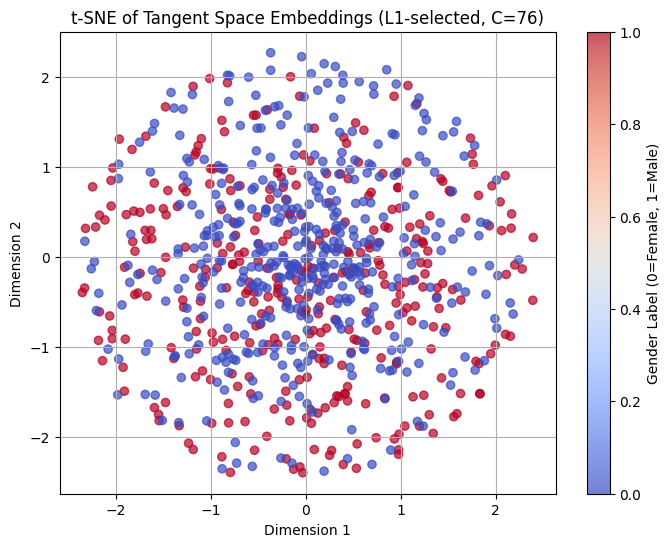

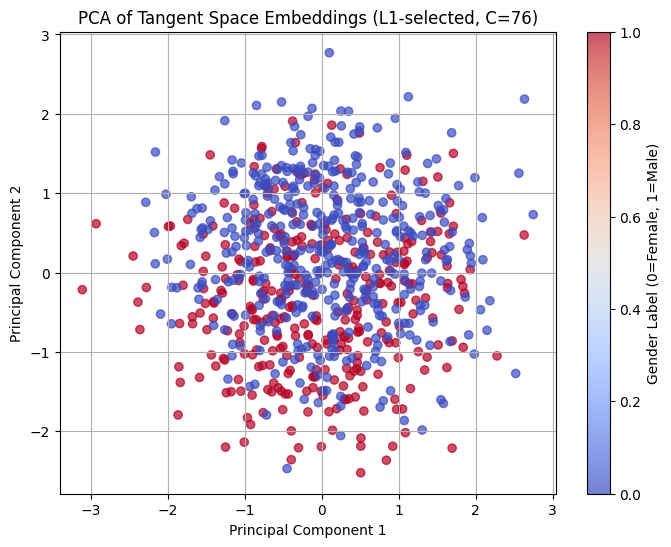

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

# 1. Rebuild the L1-based selector with the best C
best_C = study.best_params['l1_C']
l1_model = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=best_C,
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)
selector = SelectFromModel(l1_model, threshold='median')

# 2. Fit on all data and transform
X_selected = selector.fit_transform(tangent_features.astype(np.float32), labels)
print("🔹 Embeddings shape after L1 selection:", X_selected.shape)

# 3. t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d_tsne = tsne.fit_transform(X_selected)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d_tsne[:, 0], X_2d_tsne[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Gender Label (0=Female, 1=Male)')
plt.title(f"t-SNE of Tangent Space Embeddings (L1-selected, C={best_C:.2g})")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

# 4. PCA visualization
pca = PCA(n_components=2, random_state=42)
X_2d_pca = pca.fit_transform(X_selected)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d_pca[:, 0], X_2d_pca[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Gender Label (0=Female, 1=Male)')
plt.title(f"PCA of Tangent Space Embeddings (L1-selected, C={best_C:.2g})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


# **Saving Embeddings & Labels**

In [ ]:
np.save("/content/drive/MyDrive/Colab Notebooks/ML_Project/selected_tangent_embeddings.npy", X_selected)

print("✅ Embeddings saved.")

✅ Embeddings saved.


In [ ]:
np.save("/content/drive/MyDrive/Colab Notebooks/ML_Project/fmri-labels.npy", labels)